In [6]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"


import pandas as pd                                 # Data Frame

import matplotlib.pyplot as plt                     # Basic visualisation
import seaborn as sns                               # Advanced data visualisation

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Read the dataset
df = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets//clothes_size_prediction.csv')
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


## Take a look at the dataset

Show some general info about the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


Remove records with empty values

In [9]:
df = df.dropna()

What are number of records for each size?  

M: 29575  
S: 21829  
XXXL: 21259  
XL: 19033  
L: 17481  
XXS: 9907  
XXL: 69

In [10]:
df['size'].value_counts()

M       29575
S       21829
XXXL    21259
XL      19033
L       17481
XXS      9907
XXL        69
Name: size, dtype: int64

Because there are only very few records for XXL, remove those records from the dataset

In [11]:
df = df[df['size'] != 'XXL']

At first sight this seems quite a large dataset, but is this actually true?  
First we are going to change the datatype of height from float to integer.


In [12]:
df['height'] = df['height'].astype(int)

It seems reasonable to round the ages to the nearest five-fold

In [13]:
df['age'] = 5 * round(df['age']/5)

Change the datatype of age from float to integer.

In [14]:
df['age'] = df['age'].astype(int)

We drop duplicate rows in the dataset.

In [15]:
df = df.sort_values(by = ['weight','age','height','size'])
df = df.drop_duplicates(keep='first')

How many records are left?

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11306 entries, 19379 to 88415
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   weight  11306 non-null  int64 
 1   age     11306 non-null  int32 
 2   height  11306 non-null  int32 
 3   size    11306 non-null  object
dtypes: int32(2), int64(1), object(1)
memory usage: 353.3+ KB


We want to know if there are any 'wrong duplicates' in the dataset, i.e. the same values for weight, age and height, but still another size. So we count the nunique

In [17]:
help = df.groupby(['weight','age','height']).agg('nunique').reset_index()
help.head()

,weight,age,height,size
0,22,30,167,2
1,22,45,152,1
2,26,45,172,1
3,31,35,175,1
4,35,20,182,1


We want to know how many records there are with the same values for weight, age and height, but another value for size.

In [18]:
help[help['size'] > 1].count()

weight    2723
age       2723
height    2723
size      2723
dtype: int64

We decide to remove those records and to keep the first one

In [19]:
df = df.drop_duplicates(subset=['weight','age','height'],keep='first')

How many records are left?

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 19379 to 88415
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   weight  5149 non-null   int64 
 1   age     5149 non-null   int32 
 2   height  5149 non-null   int32 
 3   size    5149 non-null   object
dtypes: int32(2), int64(1), object(1)
memory usage: 160.9+ KB


Check if the dataset is heavily skewed.

In [21]:
df['size'].value_counts()

XXXL    1747
L       1695
M        672
XL       517
S        377
XXS      141
Name: size, dtype: int64

Find a way to reduce the number of records with size = XXXL and L to 1/3

In [22]:
import random
df['random'] = [random.randint(0,2) for k in df.index]
df.head(20)

,weight,age,height,size,random
19379,22,30,167,L,0
9986,22,45,152,XXXL,2
69879,26,45,172,XXXL,0
11986,31,35,175,XXXL,1
40013,35,20,182,XXXL,2
81610,36,20,157,XXS,1
88001,38,20,147,XXS,0
79608,38,30,152,XXS,1
105639,39,25,160,XXS,2
104382,39,35,160,S,0


In [23]:
df = df[((df['random'] == 0) & (df['size'] == 'L')) | ((df['random'] == 0) & (df['size'] == 'XXXL')) | ((df['size'] != 'L') & (df['size'] != 'XXXL'))]

Drop the column you won't need any more

In [24]:
df = df.drop(['random'],axis=1)

Because we want to apply regression first, map the sizes to numbers as follows:  
'XXS' : 0, 'S' : 1, 'M': 2, 'L': 3,'XL':4,'XXXL': 5

In [25]:
df['size'].value_counts()

M       672
L       551
XXXL    547
XL      517
S       377
XXS     141
Name: size, dtype: int64

What is X and what is y?

In [26]:
 mapping_dict = {'XXS':0,'S':1, 'M': 2, 'L': 3,'XL':4,'XXXL': 5}
 df['size'] = df['size'].map(mapping_dict)
 df.head()

,weight,age,height,size
19379,22,30,167,3
69879,26,45,172,5
81610,36,20,157,0
88001,38,20,147,0
79608,38,30,152,0


What is X_train, y_train, X_test, y_test?

In [27]:
X = df.drop(['size'],axis=1)
y = df['size']

What is the shape of X_train, y_train, X_test and y_test?

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [29]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2103, 3) (702, 3) (2103,) (702,)


What are the columns of X containing numbers?

In [30]:
numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns
print(numerical_ix)

Index(['weight', 'age', 'height'], dtype='object')


Define the ColumnTransformer for applying MinMaxScaling on all numeric columns.  

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
col_transform = ColumnTransformer(transformers=[('std_scaler',StandardScaler(), numerical_ix)])

## Regression

Define the model LinearRegression  

In [32]:
from sklearn.linear_model import  LinearRegression
lin_reg = LinearRegression()

Define the data preparation and modeling pipeline

In [33]:
pipeline = Pipeline([('prep',col_transform),('lin_reg',lin_reg)])

Train the model

In [34]:
X_train

,weight,age,height
9617,50,20,165
6841,64,50,172
41846,42,45,157
42,61,35,172
57172,72,40,185
...,...,...,...
9742,67,35,162
40927,57,35,147
6807,57,60,162
14833,61,30,137


In [35]:
y_train

9617     1
6841     3
41846    1
42       3
57172    2
        ..
9742     3
40927    3
6807     2
14833    2
1004     1
Name: size, Length: 2103, dtype: int64

In [36]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  Index(['weight', 'age', 'height'], dtype='object'))])),
                ('lin_reg', LinearRegression())])

What is the accuracy of the model?  
Use K-fold cross-validation with k = 3.  
Find an appropriate value for the attribute scoring on [metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html) 

In [39]:
from sklearn.model_selection import cross_val_score
-np.mean(cross_val_score(pipeline,X_train,y_train,scoring='neg_mean_squared_error',cv=3))

0.7911927795174898

-0.6977588154511789

What are the values for intercept and the coefficients.  
Why are there 3 coefficients?  
What is the most important coefficient?

In [44]:
lin_reg.intercept_

2.9025202092249174

In [45]:
lin_reg.coef_

array([ 1.18379994,  0.16491724, -0.05041805])

Apply the model to the test set.  

In [40]:
y_predict = pipeline.predict(X_test)

Calculate the Mean Absolute Error.  
Calculate the Mean Squared Error.

The mean squared error is 0.7890903524851298  
The mean absolute error is 0.6786894481965615

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_predict,squared=False)

0.9452867011842012

Change the previous code, so you get the following overview for 3 models instead of only the linear regression

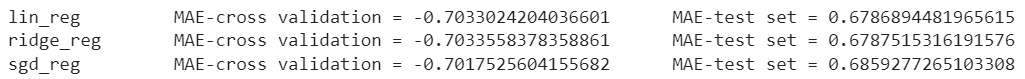

lin_reg 	MAE-cross validation = -0.6977588154511789 	MAE-test set = 0.6879995201155924
ridge_reg 	MAE-cross validation = -0.6978119094643617 	MAE-test set = 0.6880451907647683
sgd_reg 	MAE-cross validation = -0.6948621594107195 	MAE-test set = 0.6885320641092566


Create the following overview for the values 1 .. 10 for the degree of Polynomial regression.

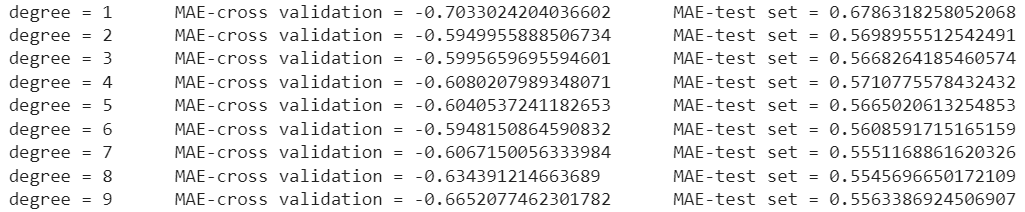

degree = 1 	MAE-cross validation = -0.6977588154511789 	MAE-test set = 0.6880008512289375
degree = 2 	MAE-cross validation = -0.593091873965248 	MAE-test set = 0.5760588367371542
degree = 3 	MAE-cross validation = -0.5862333557674282 	MAE-test set = 0.5666246152160033
degree = 4 	MAE-cross validation = -0.580259367414438 	MAE-test set = 0.557179464913155
degree = 5 	MAE-cross validation = -0.5835875716192375 	MAE-test set = 0.5459829019138515
degree = 6 	MAE-cross validation = -0.6128513860317166 	MAE-test set = 0.5290289649110124
degree = 7 	MAE-cross validation = -0.884095284606436 	MAE-test set = 0.5170450884922667
degree = 8 	MAE-cross validation = -1.1253380725891988 	MAE-test set = 0.5069831507489878
degree = 9 	MAE-cross validation = -8.554375371610641 	MAE-test set = 0.5009538736721728


##Classification

Use the softmax classifier to try to predict the class (0, 1, 2, 3, 4, 5).  
What is the accuracy score?

accuracy score is 0.5361684377998432

accuracy score is 0.5527582038321087


Create and show the confusion matrix for the test set.

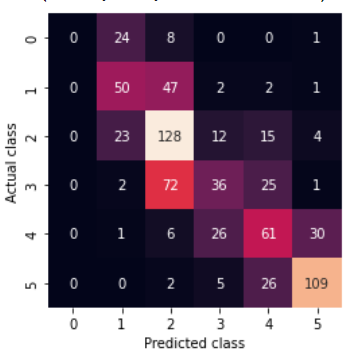

[[  0  28   1   0   0   2]
 [  0  67  32   5   2   1]
 [  0  41  70  26  16   4]
 [  0   4  50  68  29   3]
 [  0   0  10  26  71  25]
 [  0   0   1   1  33 114]]


Text(91.68, 0.5, 'Actual class')

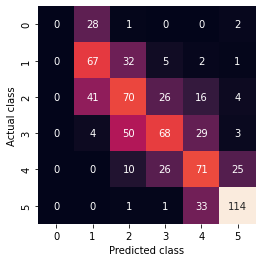

The accuracy of the classifier is really low.  
Calculate how many times 
* the classifier was correct
* the classifier predicted the size to be one size higher than the actual size
* the classifier predicted the size to be one size smaller than the actual size



correct = 390
oneSizeTooHigh = 140
oneSizeTooSmall = 150
Total number of predictions = 730
